# My solution is broken down into 5 main components
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Analysis](#Exploratory-Analysis)
- [Generating training/validation/test sets](#Generating-Train/Validation/Test-sets)
- [Training Model](#Training-Models)
- [Evaluating Model](#Evaluating-Models)

<a id=’Cleaning’></a>
# Data Cleaning

## Read in Text

In [1]:
import pandas as pd

shared_articles = pd.read_csv('shared_articles.csv')
user_interactions = pd.read_csv('users_interactions.csv')

# Only care about when articles were posted and english ones for now
shared_articles = shared_articles.loc[shared_articles["eventType"] == "CONTENT SHARED"]
shared_articles = shared_articles.loc[shared_articles["lang"] == "en"]

## Clean data

In [2]:
from urllib.parse import urlparse
import re, string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language='english')
def clean_text(text):
    """
    text: str, returns: str
    """
    text = text.lower()
    text = re.sub('\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([stemmer.stem(w) for w in text.split() if w not in ENGLISH_STOP_WORDS])
    return text

def parse_url(url):
    parsed_url = urlparse(url)
    return parsed_url.netloc

shared_articles['url'] = shared_articles['url'].apply(parse_url)
shared_articles['authorPersonId'] = shared_articles['authorPersonId'].apply(str)
shared_articles['text'] = shared_articles['text'].apply(clean_text)

## Generate Virality Scores

In [3]:
score_map = {
        "VIEW": 1,
        "LIKE": 4,
        "COMMENT CREATED": 10,
        "FOLLOW": 25,
        "BOOKMARK": 100
}

def generate_virality_score(row):    
    event_type = row["eventType"]
    row["score"] = score_map[event_type]
    
    return row

user_interactions = user_interactions.apply(generate_virality_score, axis=1)
aggregated_interactions = user_interactions.groupby(['contentId'])[['score']].sum()
aggregated_interactions = aggregated_interactions.reset_index()

## Join Data

In [4]:
# Left outer join to maintain posts with no score
joined_dataset = shared_articles.merge(aggregated_interactions, 'left', on='contentId').sort_values('score', ascending=False)

# Post with no interactions are set to 0
joined_dataset['score'] = joined_dataset['score'].fillna(0)

<a id=’Explore’></a>
# Exploratory Analysis

### I explore some of the user interactions. Some interesting statistics are
  - 9.4% of views converts into a like
  - 4% of views converts into a bookmark
  - 2.6% of views converts into a comment
  - 2.3% of views converts into a follow

eventType      
VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
dtype: int64


<AxesSubplot:xlabel='eventType'>

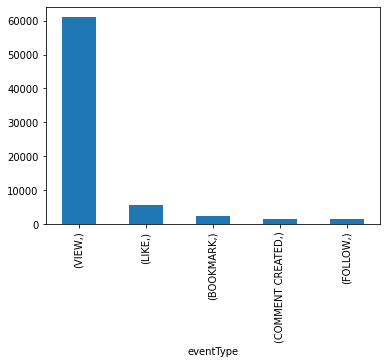

In [5]:
print(user_interactions[['eventType']].value_counts())
user_interactions[['eventType']].value_counts().plot.bar()

### Explore the two tables after joining

### From the first look after joining the two tables, the data is very skewed which makes this problem very hard to model using a regression technique. After further examination, we see that 90% of posts have a score under 324 and 99% of posts have a score under 1039. This makes me think that I should probably use a classification technique because the data is too skewed for regression.

0.10       2.0
0.20       4.0
0.50      33.0
0.80     189.0
0.90     324.0
0.95     450.5
0.99    1038.9
Name: score, dtype: float64


<AxesSubplot:>

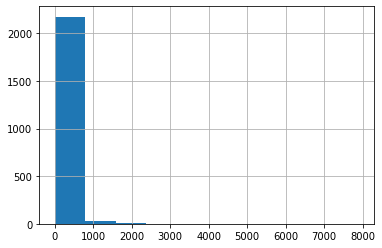

In [6]:
print(joined_dataset['score'].quantile([.1, .2, .5, .8, .9, 0.95, 0.99]))
joined_dataset['score'].hist()

### Now I attempt to analyze the number of unique values in each categorical column for one hot encoding purposes. I see that there are 754 unique urls and 187 unique authors so one hot encoding will blow up the feature space. Instead I will probably one hot encode the top 50 urls and top 50 authors.

timestamp          2210
eventType             1
contentId          2211
authorPersonId      187
authorSessionId    1417
authorUserAgent      96
authorRegion         17
authorCountry         5
contentType           3
url                 754
title              2173
text               2179
lang                  1
score               454
dtype: int64


<AxesSubplot:>

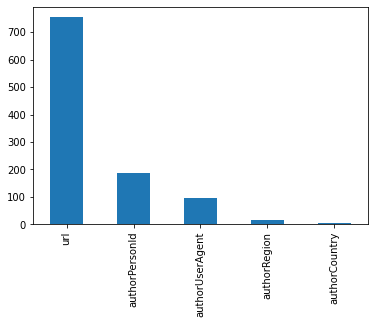

In [7]:
print(joined_dataset.nunique())
joined_dataset[[ 'url', 'authorPersonId', 'authorUserAgent', 'authorRegion', 'authorCountry']].nunique().plot.bar()

### I now view number of nulls in each feature. We see that ~79% of rows have nans for authorUserAgent, authorRegion, and authorCountry. I will drop these features because they have too many nans.

In [8]:
print("Total rows: ", len(joined_dataset.index))
joined_dataset.isna().sum()

Total rows:  2211


timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    1744
authorRegion       1744
authorCountry      1744
contentType           0
url                   0
title                 0
text                  0
lang                  0
score                 0
dtype: int64

In [9]:
joined_dataset = joined_dataset.drop(['authorUserAgent', 'authorRegion', 'authorCountry'], axis='columns')

<a id=’GenerateSets’></a>
# Generating Train/Validation/Test sets

### I will now generate the labels. I saw from exploration that predicting the virality index value for a given post will be very hard because the dataset is very skewed. Instead I will turn this into a classification problem where a post is either viral or non-viral. Viral posts are posts that acheive a score over 500. Non viral posts are any post less than 500. This threshold was choosen by looking at the quantiles which tells us only the top 5% of posts get a score of 500.

In [10]:
def generate_label(row):  
    if row.score < 500:
        row["label"] = "Not Viral"
    else:
        row["label"] = "Viral"
    
    return row

joined_dataset = joined_dataset.apply(generate_label, axis=1)

### Split into 70/15/15 split for train/validation/test sets respectively.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

features = joined_dataset.drop(['score', 'label'], axis='columns')
labels = joined_dataset['label']

print(f"Total features: {len(features)} rows, {len(features.columns)} columns")
print(f"Total labels: {len(labels)} rows")

# Intermediate rows which will be divided further into Train/Validation later using different random states
X_intermediate, X_test, y_intermediate, y_test = train_test_split(features, 
                                                                  labels, 
                                                                  test_size=0.15, 
                                                                  random_state=0,
                                                                  stratify=labels)

# Intermediate rows are divided further into Train and Validation
X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate, 
                                                                y_intermediate, 
                                                                test_size=0.17, 
                                                                random_state=0,
                                                                stratify=y_intermediate)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_validation)}")
print(f"Test size: {len(X_test)}")

Total features: 2211 rows, 10 columns
Total labels: 2211 rows
Train size: 1559
Validation size: 320
Test size: 332


### I perform one-hot-encoding on the 50 most frequent urls and 50 most frequent authors. I only look at the frequencies in the training data to avoid data leakage.

In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

# Generate Categorical features
top_50_urls = [x for x in X_train.url.value_counts().sort_values(ascending=False).head(50).index]
top_50_authors = [x for x in X_train.authorPersonId.value_counts().sort_values(ascending=False).head(50).index]

for label in top_50_urls:
    X_train[label] = np.where(X_train['url'] == label, 1, 0)
    X_validation[label] = np.where(X_validation['url'] == label, 1, 0)
    X_test[label] = np.where(X_test['url'] == label, 1, 0)

for label in top_50_authors:
    X_train[label] = np.where(X_train['authorPersonId'] == label, 1, 0)
    X_validation[label] = np.where(X_validation['authorPersonId'] == label, 1, 0)
    X_test[label] = np.where(X_test['authorPersonId'] == label, 1, 0)

### Train a TF-IDF vectorizer on the training set text

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Limit max features to 1000 to keep the number of features smaller than my rows
vectorizer = TfidfVectorizer(min_df=2, max_df=.5, max_features=1000)
vectorizer.fit(X_train["text"])

TfidfVectorizer(max_df=0.5, max_features=1000, min_df=2)

### Generate features as numpy arrays

In [14]:
import numpy as np

def generate_feature_arr(feature_df, vectorizer):
    # Generate features as NumPy arrays
    text_arr = vectorizer.transform(feature_df["text"]).toarray()
    url_arr = feature_df[[label for label in top_50_urls]].to_numpy()
    author_arr = feature_df[[label for label in top_50_authors]].to_numpy()
    
    final_arr = np.append(text_arr, url_arr, axis=1)
    final_arr = np.append(final_arr, author_arr, axis=1)
    return final_arr

X_train = generate_feature_arr(X_train, vectorizer)
X_validation = generate_feature_arr(X_validation, vectorizer)
X_test = generate_feature_arr(X_test, vectorizer)

print("Train feature shape: ", X_train.shape)
print("Validation feature shape: ", X_validation.shape)
print("Test feature shape: ", X_test.shape)

Train feature shape:  (1559, 1100)
Validation feature shape:  (320, 1100)
Test feature shape:  (332, 1100)


<a id=’Train’></a>
# Training Models

In [15]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Custom prediction model to allow me to optimize for precision or recall
def custom_predict(classifier, data_points):
    y_pred = (classifier.predict_proba(data_points)[:,1] >= 0.055)
    predictions = ["Viral" if pred else "Not Viral" for pred in y_pred]
    
    return predictions

def compute_metrics(classifier, model_name):
    predictions = custom_predict(classifier, X_validation)
    
    acc = accuracy_score(y_validation, predictions)
    prec = precision_score(y_validation, predictions, pos_label='Viral')
    rec = recall_score(y_validation, predictions, pos_label='Viral')
    
    print(f"{model_name} scores: \n  Accuracy: {round(acc * 100, 2)}%\n  Precision: {round(prec * 100, 2)}%\n  Recall: {round(rec * 100, 2)}%")

# LogisticRegression
lr = LogisticRegression(random_state=1, solver='lbfgs').fit(X_train, y_train)
compute_metrics(lr, "Logistic Regression")

# Naive Bayes, with Bernoulli distribution
nv_bd = BernoulliNB().fit(X_train, y_train)
compute_metrics(nv_bd, "Naive Bayes")

# Decision tree, use 20 for min_samples_split to prevent overfitting
dtc = DecisionTreeClassifier(random_state=1, min_samples_split=20).fit(X_train, y_train)
compute_metrics(dtc, "Decision Trees")

# Random Forest, with a 100 estimators and use min_samples_split
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=1).fit(X_train, y_train)
compute_metrics(rfc, "Random Forest Classifier")

Logistic Regression scores: 
  Accuracy: 84.38%
  Precision: 13.73%
  Recall: 53.85%
Naive Bayes scores: 
  Accuracy: 79.69%
  Precision: 9.38%
  Recall: 46.15%
Decision Trees scores: 
  Accuracy: 86.88%
  Precision: 3.23%
  Recall: 7.69%
Random Forest Classifier scores: 
  Accuracy: 69.69%
  Precision: 9.62%
  Recall: 76.92%


<a id=’Eval’></a>
# Evaluating Models

## Going with the Linear Regression model because it was able to predict ~54% of the viral videos with decent accuracy. I retrain the Linear Regressor on both the training and validation. Seeing some promising results with ~85% for both accuracy and recall.

In [16]:
# Train data on all of the training data (train & val) before testing
X_combined = np.concatenate((X_train, X_validation))
y_combined = np.append(y_train, y_validation)

lr = LogisticRegression(random_state=1, solver='lbfgs').fit(X_combined, y_combined)
compute_metrics(lr, "Logistic Regression")

Logistic Regression scores: 
  Accuracy: 85.94%
  Precision: 20.37%
  Recall: 84.62%


## Looks like it did slightly worse on the test set with 79.52% accuracy and only 57% recall. Further hyper-parameter tuning can achieve better results but I will leave this for future work.

In [17]:
# Test on test
predictions = custom_predict(lr, X_test)
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions, pos_label='Viral')
rec = recall_score(y_test, predictions, pos_label='Viral')

print(f"Scores from the best model: \n  Accuracy: {round(acc * 100, 2)}%\n  Precision: {round(prec * 100, 2)}%\n  Recall: {round(rec * 100, 2)}%")

Scores from the best model: 
  Accuracy: 79.52%
  Precision: 11.43%
  Recall: 57.14%
